# Imports

In [1]:
from torchsummary import summary
import os
import cv2
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
from time import time
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import Subset
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Utils

In [2]:
def plot_image(image, title="Imagem", cmap='gray'):
    # Converte de BGR para RGB se a imagem for colorida
    if len(image.shape) == 3:  # Imagem colorida
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')  # Oculta os eixos
    plt.show()

In [3]:
def is_grayscale_rgb(image: Image.Image) -> bool:
    # Converter imagem para array NumPy
    img_array = np.array(image)
    
    # Verificar se a imagem é RGB
    if img_array.ndim == 3 and img_array.shape[2] == 3:
        # Comparar os canais R, G e B
        return np.all(img_array[..., 0] == img_array[..., 1]) and np.all(img_array[..., 1] == img_array[..., 2])
    return False

In [4]:
def show_image_and_histogram(img, title_image="Image", title_hist="Histogram", bins=256):
    # plotar imagem de um lado e do outro o histograma
    plt.figure(figsize=(15, 5))

    # Adicionar a imagem
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title(title_image)
    plt.axis("off")

    # Adicionar o histograma da imagem
    plt.subplot(1, 2, 2)
    plt.hist(np.array(img).ravel(), bins=bins, color="black")
    plt.title(title_hist)
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [5]:
def denormalize(img, mean, std):
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

def convert_normalized_to_255(img):
    img = np.clip(img, 0, 1)
    img_255 = (img * 255).astype(np.uint8)
    return img_255

In [6]:
# Setting up file paths
train_path = '/kaggle/input/kermany2018/OCT2017 /train'
test_path = '/kaggle/input/kermany2018/OCT2017 /test'
val_path = '/kaggle/input/kermany2018/OCT2017 /val'

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load Data

In [8]:
data_directory = train_path # No artigo, o autor utiliza apenas o diretório de treino para fazer o split em treino, teste e validação

In [9]:
split_train, split_val, split_test = 0.9016, 0.0184, 0.08
split_data = [split_train, split_val, split_test]
batch_size = 84

In [10]:
raw_dataset = datasets.ImageFolder(root=data_directory)

In [11]:
raw_dataset

Dataset ImageFolder
    Number of datapoints: 83484
    Root location: /kaggle/input/kermany2018/OCT2017 /train

# Preprocessing data

In [12]:
mean, std = 0.18484567, 0.15903676
resize = (150, 150)
center_crop = (128, 128)
input_size = (128, 128)

In [13]:
input_channels = 3 # quantidade de canais presentes na imagem

In [14]:
transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.CenterCrop(center_crop),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean, mean, mean] , std=[std, std, std])
])

In [15]:
dataset = datasets.ImageFolder(root=data_directory, transform=transform)

In [16]:
train_dataset, val_dataset, test_dataset = random_split(dataset, split_data)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [18]:
def enhance_image(img):
    img = np.array(img)
    original_img = img.copy()

    # Converter para tons de cinza, se necessário
    if len(img.shape) == 3 and img.shape[2] == 3:  
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Aplicar o filtro de mediana
    img = cv2.medianBlur(img, 5)
    plot_image(img, "Mediana")

    # Aplicar CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    plot_image(img, "CLAHE - (Contrast Limited Adaptive Histogram Equalization)")

    # Segmentar a imagem com o threshold de Otsu
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plot_image(img_bin, "Segmentação - (Thresh Otsu)")

    # Remover ruídos com operação de morfológica
    el = (11, 11)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, el)
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel, iterations=1)

    plot_image(img_bin, f"Abertura - {el}")
    
    # Extrair contornos
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Criar uma máscara binária a partir dos contornos
    mask = np.zeros_like(img_bin)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)  # Preencher os contornos
    plot_image(img_bin, f"Preencher os contornos")
    
    # Multiplicar a imagem original pela máscara binária
    if len(original_img.shape) == 3:  # Se a imagem original for colorida
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)  # Converter a máscara para RGB
        enhanced_img = cv2.bitwise_and(original_img, mask)  # Aplicar a máscara
    else:
        enhanced_img = cv2.bitwise_and(original_img, mask)  # Aplicar a máscara (imagem em tons de cinza)
    
    # Converter o array numpy de volta para um objeto PIL.Image
    return Image.fromarray(enhanced_img)


enhancement_transform  = transforms.Compose([
    transforms.Lambda(lambda x: enhance_image(x)),
    
    transforms.Resize(resize),
    transforms.CenterCrop(center_crop),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean],  std=[std])
])


In [19]:
enhanced_dataset = datasets.ImageFolder(root=data_directory, transform=enhancement_transform)

In [20]:
enhanced_train_dataset, enhanced_val_dataset, enhanced_test_dataset = random_split(enhanced_dataset, split_data)

In [21]:
enhanced_train_loader = DataLoader(enhanced_train_dataset, batch_size=batch_size, shuffle=True)
enhanced_test_loader = DataLoader(enhanced_test_dataset, batch_size=batch_size, shuffle=False)
enhanced_val_loader = DataLoader(enhanced_val_dataset, batch_size=batch_size, shuffle=False)

# Data Analysis

In [22]:
# img, label = raw_dataset[0]
img, label = raw_dataset[15]


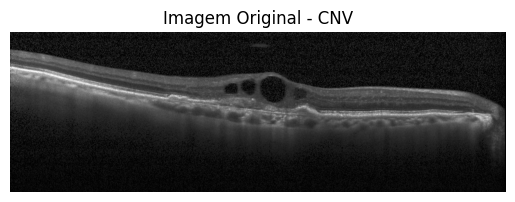

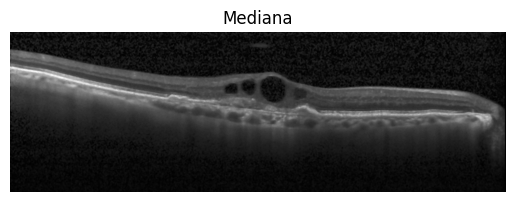

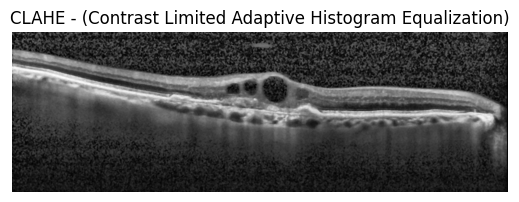

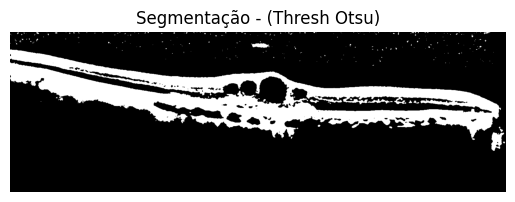

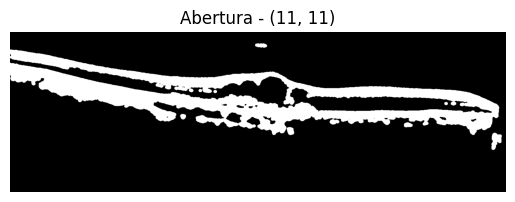

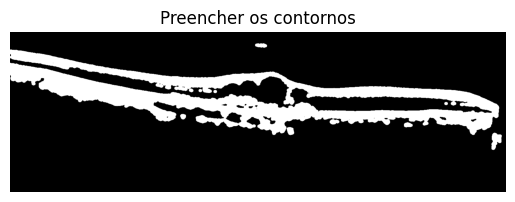

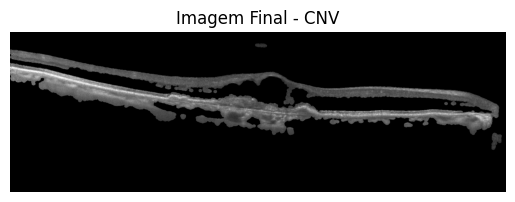

In [23]:
def enhance_image_pipe(img):
    img = np.array(img)
    original_img = img.copy()

    # Converter para tons de cinza, se necessário
    if len(img.shape) == 3 and img.shape[2] == 3:  
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Aplicar o filtro de mediana
    img = cv2.medianBlur(img, 5)
    plot_image(img, "Mediana")

    # Aplicar CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    plot_image(img, "CLAHE - (Contrast Limited Adaptive Histogram Equalization)")

    # Segmentar a imagem com o threshold de Otsu
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plot_image(img_bin, "Segmentação - (Thresh Otsu)")

    # Remover ruídos com operação de morfológica
    el = (11, 11)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, el)
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel, iterations=1)

    plot_image(img_bin, f"Abertura - {el}")
    
    # Extrair contornos
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Criar uma máscara binária a partir dos contornos
    mask = np.zeros_like(img_bin)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)  # Preencher os contornos
    plot_image(img_bin, f"Preencher os contornos")
    
    # Multiplicar a imagem original pela máscara binária
    if len(original_img.shape) == 3:  # Se a imagem original for colorida
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)  # Converter a máscara para RGB
        enhanced_img = cv2.bitwise_and(original_img, mask)  # Aplicar a máscara
    else:
        enhanced_img = cv2.bitwise_and(original_img, mask)  # Aplicar a máscara (imagem em tons de cinza)
    
    # Converter o array numpy de volta para um objeto PIL.Image
    return Image.fromarray(enhanced_img)


plot_image(np.array(img), f"Imagem Original - {raw_dataset.classes[label]}")
t = enhance_image_pipe(img)
plot_image(np.array(t), f"Imagem Final - {raw_dataset.classes[label]}")


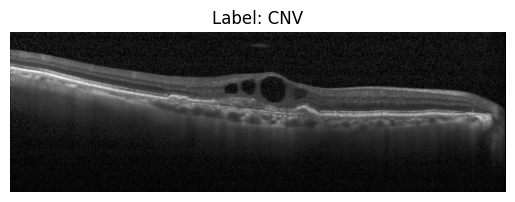

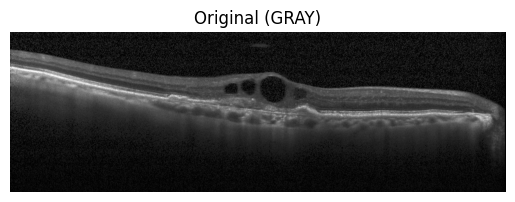

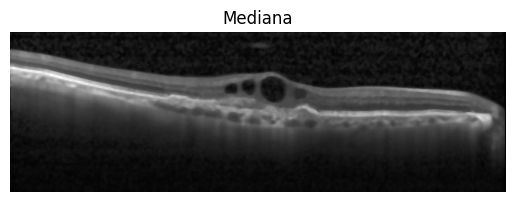

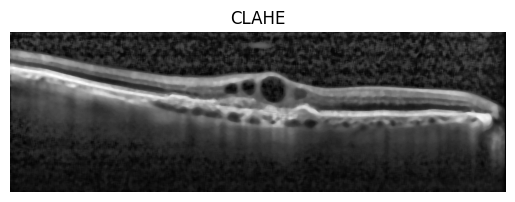

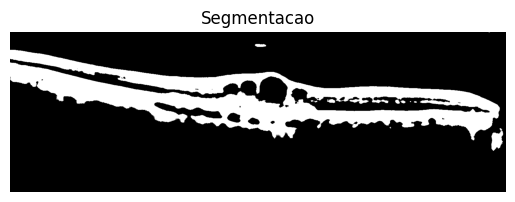

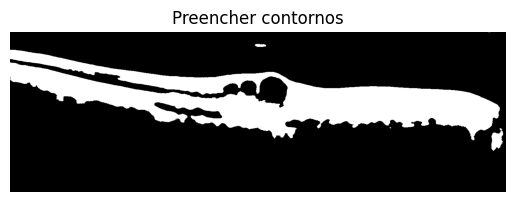

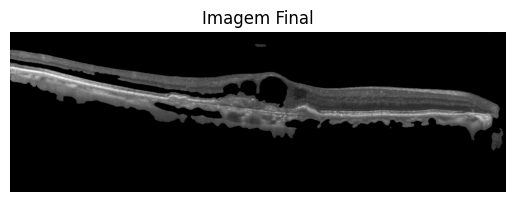

In [24]:
def enhance_image_modified_pipe(img):
    img = np.array(img)
    original_img = img.copy()

    # Converter para tons de cinza, se necessário
    if len(img.shape) == 3 and img.shape[2] == 3:  
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    original_gray = img.copy()
    plot_image(original_gray, "Original (GRAY)")
    
    # Aplicar o filtro de mediana
    img = cv2.medianBlur(img, 11)
    plot_image(img, "Mediana")
    
    # Aplicar CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    plot_image(img, "CLAHE")

    # Segmentar a imagem com o threshold de Otsu
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plot_image(img_bin, "Segmentacao")
    
    # Extrair contornos
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
     # Criar uma máscara binária a partir dos contornos
    mask = np.zeros_like(img_bin)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)  # Preencher os contornos
    plot_image(mask, "Preencher contornos")

    # # Aplica o filtro minimo/erosão
    # mask = cv2.erode(mask,  np.ones((15, 15), np.uint8))
    # plot_image(mask, "Erosão")
    
    # Multiplicar a imagem original pela máscara binária
    enhanced_img = cv2.bitwise_and(original_gray, mask)
    # Converter o array numpy de volta para um objeto PIL.Image
    return Image.fromarray(enhanced_img)


plot_image(np.array(img), f"Label: {raw_dataset.classes[label]}")
t = enhance_image_modified_pipe(img)
plot_image(np.array(t), "Imagem Final")

# Mod

In [25]:
def enhance_image_mod(img):
    img = np.array(img)
    original_img = img.copy()
    if len(img.shape) == 3 and img.shape[2] == 3:  
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    original_gray = img.copy()
    img = cv2.medianBlur(img, 11)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(img_bin)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED) # Preencher os contornos
    enhanced_img = cv2.bitwise_and(original_gray, mask)
    return Image.fromarray(enhanced_img)


enhancement_transform_mod  = transforms.Compose([
    transforms.Lambda(lambda x: enhance_image_mod(x)),
    
    transforms.Resize(resize),
    transforms.CenterCrop(center_crop),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[mean],  std=[std]) # NAO NORMALIZAR COM NORMALIZACAO PADRAO (JÁ TÁ [0, 1])
])

enhanced_dataset_mod = datasets.ImageFolder(root=data_directory, transform=enhancement_transform_mod)

enhanced_train_dataset_mod, enhanced_val_dataset_mod, enhanced_test_dataset_mod = random_split(enhanced_dataset_mod, split_data)

enhanced_train_loader_mod = DataLoader(enhanced_train_dataset_mod, batch_size=batch_size, shuffle=True)
enhanced_test_loader_mod = DataLoader(enhanced_test_dataset_mod, batch_size=batch_size, shuffle=False)
enhanced_val_loader_mod = DataLoader(enhanced_val_dataset_mod, batch_size=batch_size, shuffle=False)

# Convolutional Neural Network Architectures

## Architectures

In [26]:
class CNN5(nn.Module):
    def __init__(self, input_channels, image_size = (128, 128)):
        super(CNN5, self).__init__()
        
        self.n = 4 # número de operacoes de pooling

        # calcular resolução final baseada no image_size
        self.height, self.width = image_size
        self.final_height = self.height // (2 ** self.n)
        self.final_width = self.width // (2 ** self.n)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.conv1_1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)

        self.flattened_input_size = 48 * self.final_height * self.final_width
        self.fc1 = nn.Linear(self.flattened_input_size, 1536)
        self.fc2 = nn.Linear(1536, 512)
        self.fc3 = nn.Linear(512, 4)  

        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2_1(x))
        x = self.pool(x) 
        
        x = F.relu(self.conv3_1(x))          
        x = F.relu(self.conv3_2(x))
        x = self.pool(x)  
        
        x = F.relu(self.conv4_1(x))
        x = self.pool(x) 
        
        x = x.view(-1, self.flattened_input_size)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [27]:
class CNN7(nn.Module):
    def __init__(self, input_channels, image_size = (128, 128)):
        super(CNN7, self).__init__()
        
        self.n = 4 # número de operacoes de pooling

        # calcular resolução final baseada no image_size
        self.height, self.width = image_size
        self.final_height = self.height // (2 ** self.n)
        self.final_width = self.width // (2 ** self.n)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1_1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)

        self.flattened_input_size = 48 * self.final_height * self.final_width
        self.fc1 = nn.Linear(self.flattened_input_size, 1536)
        self.fc2 = nn.Linear(1536, 512)
        self.fc3 = nn.Linear(512, 4)

        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = self.pool(x) 
        
        x = F.relu(self.conv2_1(x))        
        x = F.relu(self.conv2_2(x))
        x = self.pool(x)  
        
        x = F.relu(self.conv3_1(x))          
        x = F.relu(self.conv3_2(x))           
        x = F.relu(self.conv3_3(x))   
        x = self.pool(x)   
        
        x = F.relu(self.conv4_1(x))
        x = self.pool(x)   
        
        x = x.view(-1, self.flattened_input_size)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x



In [28]:
class CNN9(nn.Module):
    def __init__(self, input_channels, image_size = (128, 128)):
        super(CNN9, self).__init__()
        
        self.n = 4 # número de operacoes de pooling

        # calcular resolução final baseada no image_size
        self.height, self.width = image_size
        self.final_height = self.height // (2 ** self.n)
        self.final_width = self.width // (2 ** self.n)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1_1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1)

        self.flattened_input_size = 64 * self.final_height * self.final_width
        self.fc1 = nn.Linear(64 * self.final_height * self.final_width, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 4)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = self.pool(x) 
        
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3_1(x))          
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool(x) 
        
        x = F.relu(self.conv4_1(x)) 
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool(x)
        
        x = x.view(-1, self.flattened_input_size)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

## Initializing CNNs

In [29]:
# Hiperparâmetros
learning_rate = 0.001

# config
# epochs = 10
epochs = 15
# epochs = 10 if device != "cpu" else 1

In [30]:
model_cnn5 = CNN5(input_channels=input_channels).to(device) 
criterion_cnn5 = nn.NLLLoss()
optimizer_cnn5 = optim.Adam(model_cnn5.parameters(), lr=learning_rate)
model_cnn5

CNN5(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3072, out_features=1536, bias=True)
  (fc2): Linear(in_features=1536, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [31]:
model_cnn7 = CNN7(input_channels=input_channels).to(device) 
criterion_cnn7 = nn.NLLLoss()
optimizer_cnn7 = optim.Adam(model_cnn7.parameters(), lr=learning_rate)
model_cnn7

CNN7(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3072, out_features=1536, bias=True)
  (fc2): Linear(in_features=1536, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [32]:
model_cnn9 = CNN9(input_channels=input_channels).to(device) 
criterion_cnn9 = nn.NLLLoss()
optimizer_cnn9 = optim.Adam(model_cnn9.parameters(), lr=learning_rate)
model_cnn9

CNN9(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (dropout): D

In [33]:
# model_cnn7_enhanced = CNN7(input_channels=input_channels).to(device) 
# criterion_cnn7_enhanced = nn.NLLLoss()
# optimizer_cnn7_enhanced = optim.Adam(model_cnn7_enhanced.parameters(), lr=learning_rate)
# model_cnn7_enhanced

In [34]:
# model_cnn7_enhanced_mod = CNN7(input_channels=1).to(device) 
# criterion_cnn7_enhanced_mod = nn.NLLLoss()
# optimizer_cnn7_enhanced_mod = optim.Adam(model_cnn7_enhanced_mod.parameters(), lr=learning_rate)
# model_cnn7_enhanced_mod

## Treinamento

### Utils

In [35]:
def train(model, train_loader, epochs=10, optimizer=None, criterion=None):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=True):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  
            optimizer.step()  
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)  

def train_val(model, train_loader, val_loader, epochs=10, optimizer=None, criterion=None, device='cpu', validate_every_k=20):
    history = {
        "training_loss": [],
        "validation_loss": [],
        "val_accuracy": []
    }

    model.to(device)
    global_step = 0


    for epoch in range(epochs):
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=True)
        model.train()  
        for inputs, labels in progress_bar:
            global_step += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() 
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  


            if val_loader and global_step % validate_every_k == 0:
                model.eval()  # Modo de avaliação
                val_loss, correct, total = 0.0, 0, 0
    
                with torch.no_grad():
                    for val_inputs, val_labels in val_loader:
                        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                        val_outputs = model(val_inputs)
                        val_loss += criterion(val_outputs, val_labels).item()
                        _, predicted = torch.max(val_outputs, 1)
                        total += val_labels.size(0)
                        correct += (predicted == val_labels).sum().item()
                avg_val_loss = val_loss / len(val_loader)
                val_accuracy = correct / total
                history["training_loss"].append(loss.item())
                history["validation_loss"].append(avg_val_loss)
                history["val_accuracy"].append(val_accuracy)
                
                progress_bar.set_postfix({
                        "Training loss": f"{loss.item():.4f}",
                        "Validation loss":  f"{avg_val_loss:.4f}", 
                        "Validation Accuracy": f"{val_accuracy:.4f}",
                    })
    return history


### Train

In [36]:
i = time()
train(model_cnn5, train_loader, epochs=epochs, optimizer=optimizer_cnn5, criterion=criterion_cnn5)
f = time()
print("Time:", f-i)

Epoch 15/15: 100%|██████████| 897/897 [06:25<00:00,  2.33it/s]

Time: 6174.736591339111


In [37]:
i = time()
train(model_cnn7, train_loader, epochs=epochs, optimizer=optimizer_cnn7, criterion=criterion_cnn7)
f = time()
print("Time:", f-i)


Epoch 15/15: 100%|██████████| 897/897 [06:39<00:00,  2.25it/s]

Time: 5938.143540859222


In [38]:
i = time()
train(model_cnn9, train_loader, epochs=epochs, optimizer=optimizer_cnn9,criterion=criterion_cnn9)
f = time()
print("Time:", f-i)

Epoch 15/15: 100%|██████████| 897/897 [06:49<00:00,  2.19it/s]

Time: 6057.302951335907


In [39]:
# i = time()
# train(model_cnn7_enhanced, enhanced_train_loader, epochs=epochs, optimizer=optimizer_cnn7_enhanced, criterion=criterion_cnn7_enhanced)
# f = time()
# print("Time:", f-i)

In [40]:
# i = time()
# train(model_cnn7_enhanced_mod, enhanced_train_loader_mod, epochs=epochs, optimizer=optimizer_cnn7_enhanced_mod,criterion=criterion_cnn7_enhanced_mod)
# f = time()
# print("Time:", f-i)

In [41]:
# i = time()

# history_cnn5 = train(
#     model_cnn5,
#     train_loader,
#     val_loader= val_loader,
#     epochs=epochs,
#     optimizer=optimizer_cnn5,
#     criterion=criterion_cnn5,
#     device=device,
# )

# f = time()
# print(f"Time: {f-i}")

In [42]:
# i = time()

# history_cnn7 = train(
#     model_cnn7,
#     train_loader,
#     val_loader,
#     epochs=epochs,
#     optimizer=optimizer_cnn7,
#     criterion=criterion_cnn7,
#     device=device,
#     validate_every_k=1)

# f = time()
# print(f"Time: {f-i}")

In [43]:
# i = time()

# history_cnn9 = train(
#     model_cnn9,
#     train_loader,
#     val_loader,
#     epochs=epochs,
#     optimizer=optimizer_cnn9,
#     criterion=criterion_cnn9,
#     device=device,
#     validate_every_k=1)

# f = time()
# print(f"Time: {f-i}")

In [44]:
# i = time()

# history_cnn7_enhanced = train(
#     model_cnn7_enhanced,
#     enhanced_train_loader,
#     enhanced_val_loader,
#     epochs=epochs,
#     optimizer=optimizer_cnn7_enhanced,
#     criterion=criterion_cnn7_enhanced,
#     device=device,
#     validate_every_k=1)
# f = time()

# print(f"Time: {f-i}")

## Validation

### Utils

In [45]:
def eval(model, test_loader):
    model.eval()  # Coloca o modelo em modo de avaliação
    all_preds, all_labels = [], []
    with torch.no_grad():  # Desabilitar o cálculo de gradiente para economizar memória
        for inputs, labels in tqdm(test_loader, desc="Test Progress", leave=True):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

In [46]:
def calculate_metrics(cm, classes): 
    metrics = {}
    
    # Para cada classe
    for i, class_name in enumerate(classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP  # Soma da coluna - TP
        FN = cm[i, :].sum() - TP  # Soma da linha - TP
        TN = cm.sum() - (TP + FP + FN)
    
        # accuracy = (TP + TN) / cm.sum()
        accuracy = (TP + TN) / (FP + FN + TP + TN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0 
        f1_score = (2 * TP) / (FP + FN + (2* TP)) if (FP + FN + (2* TP)) > 0 else 0
        
        metrics[class_name] = {
            "Acurácia": accuracy,
            "Precision": precision,
            "Sensitivity/Recall": sensitivity,
            "Specificity": specificity,
            "F1-Score": f1_score
        }
    
    return pd.DataFrame(metrics)

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score

def calculate_metrics_per_class(y_true, y_pred, class_names=None):
    unique_classes = sorted(set(y_true))
    metrics_per_class = {}
    for idx, class_label in enumerate(unique_classes):
        precision = precision_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)    
        class_name = class_names[class_label] if class_names else class_label
        metrics_per_class[class_name] = {
            "precision": precision,
            "recall": recall,
        }
    return metrics_per_class

def calculate_overall_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = cm.diagonal() / cm.sum(axis=1)
    avg_sensitivity = sensitivity.mean()
    specificity = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
    avg_specificity = sum(specificity) / len(specificity)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)
    return {
        "accuracy": accuracy,
        "sensitivity": avg_sensitivity,
        "specificity": avg_specificity,
        "f1_score": f1,
        "kappa": kappa
    }

### Eval

In [48]:
all_preds_cnn5, all_labels_cnn5 = eval(model_cnn5, test_loader)

Test Progress: 100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


In [49]:
all_preds_cnn7, all_labels_cnn7 = eval(model_cnn7, test_loader)

Test Progress: 100%|██████████| 80/80 [00:34<00:00,  2.34it/s]


In [50]:
all_preds_cnn9, all_labels_cnn9 = eval(model_cnn9, test_loader)

Test Progress: 100%|██████████| 80/80 [00:34<00:00,  2.34it/s]


In [51]:
# all_preds_cnn7_enhanced, all_labels_cnn7_enhanced = eval(model_cnn7_enhanced, enhanced_test_loader)

In [52]:
# all_preds_cnn7_enhanced_mod, all_labels_cnn7_enhanced_mod = eval(model_cnn7_enhanced_mod, enhanced_test_loader_mod)

### Confusion Matrix

In [53]:
cm_cnn5 = confusion_matrix(all_labels_cnn5, all_preds_cnn5)
pd.DataFrame(cm_cnn5, index = dataset.classes, columns = dataset.classes)

,CNV,DME,DRUSEN,NORMAL
CNV,2845,26,79,5
DME,31,879,3,23
DRUSEN,33,1,634,41
NORMAL,9,32,24,2013


In [54]:
cm_cnn7 = confusion_matrix(all_labels_cnn7, all_preds_cnn7)
pd.DataFrame(cm_cnn7, index = dataset.classes, columns = dataset.classes)

,CNV,DME,DRUSEN,NORMAL
CNV,2854,23,71,7
DME,32,844,6,54
DRUSEN,44,0,639,26
NORMAL,7,12,37,2022


In [55]:
cm_cnn9 = confusion_matrix(all_labels_cnn9, all_preds_cnn9)
pd.DataFrame(cm_cnn9, index = dataset.classes, columns = dataset.classes)

,CNV,DME,DRUSEN,NORMAL
CNV,2903,5,44,3
DME,67,813,9,47
DRUSEN,61,1,621,26
NORMAL,19,17,46,1996


In [56]:
# cm_cnn7_enhanced = confusion_matrix(all_labels_cnn7_enhanced, all_preds_cnn7_enhanced)
# pd.DataFrame(cm_cnn7_enhanced, index = dataset.classes, columns = dataset.classes)

In [57]:
# cm_cnn7_enhanced_mod = confusion_matrix(all_labels_cnn7_enhanced_mod, all_preds_cnn7_enhanced_mod)
# pd.DataFrame(cm_cnn7_enhanced_mod, index = dataset.classes, columns = dataset.classes)

### Metrics

In [58]:
calculate_metrics(cm_cnn5, dataset.classes)

,CNV,DME,DRUSEN,NORMAL
Acurácia,0.972597,0.982630,0.972896,0.979934
Precision,0.974983,0.937100,0.856757,0.966859
Sensitivity/Recall,0.962775,0.939103,0.894217,0.968720
Specificity,0.980392,0.989725,0.982242,0.985000
F1-Score,0.968840,0.938100,0.875086,0.967788


In [59]:
calculate_metrics(cm_cnn7, dataset.classes)

,CNV,DME,DRUSEN,NORMAL
Acurácia,0.972447,0.980982,0.972447,0.978586
Precision,0.971740,0.960182,0.848606,0.958748
Sensitivity/Recall,0.965821,0.901709,0.901269,0.973051
Specificity,0.977706,0.993905,0.980901,0.981087
F1-Score,0.968771,0.930028,0.874145,0.965847


In [60]:
calculate_metrics(cm_cnn9, dataset.classes)

,CNV,DME,DRUSEN,NORMAL
Acurácia,0.970201,0.978137,0.971998,0.976340
Precision,0.951803,0.972488,0.862500,0.963320
Sensitivity/Recall,0.982403,0.868590,0.875882,0.960539
Specificity,0.960516,0.995994,0.983414,0.983478
F1-Score,0.966861,0.917607,0.869139,0.961928


In [61]:
# calculate_metrics(cm_cnn7_enhanced, dataset.classes)

In [62]:
# calculate_metrics(cm_cnn7_enhanced_mod, dataset.classes)

### Metrics(macro)

In [63]:
metrics_macro_cnn5 = calculate_overall_metrics(y_true = all_labels_cnn5, y_pred = all_preds_cnn5)
for metric in metrics_macro_cnn5:
    print(f"{metric:20s}\t{metrics_macro_cnn5[metric] * 100:0.2f}%")

accuracy            	95.40%
sensitivity         	94.12%
specificity         	98.43%
f1_score            	93.75%
kappa               	93.22%


In [64]:
metrics_macro_cnn7 = calculate_overall_metrics(y_true = all_labels_cnn7, y_pred = all_preds_cnn7)
for metric in metrics_macro_cnn7:
    print(f"{metric:20s}\t{metrics_macro_cnn7[metric] * 100:0.2f}%")

accuracy            	95.22%
sensitivity         	93.55%
specificity         	98.34%
f1_score            	93.47%
kappa               	92.94%


In [65]:
metrics_macro_cnn9 = calculate_overall_metrics(y_true = all_labels_cnn9, y_pred = all_preds_cnn9)
for metric in metrics_macro_cnn9:
    print(f"{metric:20s}\t{metrics_macro_cnn9[metric] * 100:0.2f}%")

accuracy            	94.83%
sensitivity         	92.19%
specificity         	98.09%
f1_score            	92.89%
kappa               	92.32%


In [66]:
# metrics_macro_cnn7_enhanced = calculate_overall_metrics(y_true = all_labels_cnn7_enhanced, y_pred = all_preds_cnn7_enhanced)
# for metric in metrics_macro_cnn7_enhanced:
#     print(f"{metric:20s}\t{metrics_macro_cnn7_enhanced[metric] * 100:0.2f}%")

In [67]:
# metrics_macro_cnn7_enhanced_mod = calculate_overall_metrics(y_true = all_labels_cnn7_enhanced_mod, y_pred = all_preds_cnn7_enhanced_mod)
# for metric in metrics_macro_cnn7_enhanced_mod:
#     print(f"{metric:20s}\t{metrics_macro_cnn7_enhanced_mod[metric] * 100:0.2f}%")

### Metrics(local)

In [68]:
metrics_local_cnn5 = calculate_metrics_per_class(y_true=all_labels_cnn5, y_pred=all_preds_cnn5, class_names=dataset.classes)
pd.DataFrame(metrics_local_cnn5)

,CNV,DME,DRUSEN,NORMAL
precision,0.974983,0.937100,0.856757,0.966859
recall,0.962775,0.939103,0.894217,0.968720


In [69]:
metrics_local_cnn7 = calculate_metrics_per_class(y_true=all_labels_cnn7, y_pred=all_preds_cnn7, class_names=dataset.classes)
pd.DataFrame(metrics_local_cnn7)

,CNV,DME,DRUSEN,NORMAL
precision,0.971740,0.960182,0.848606,0.958748
recall,0.965821,0.901709,0.901269,0.973051


In [70]:
metrics_local_cnn9 = calculate_metrics_per_class(y_true=all_labels_cnn9, y_pred=all_preds_cnn9, class_names=dataset.classes)
pd.DataFrame(metrics_local_cnn9)

,CNV,DME,DRUSEN,NORMAL
precision,0.951803,0.972488,0.862500,0.963320
recall,0.982403,0.868590,0.875882,0.960539


In [71]:
# metrics_local_cnn7_enhanced = calculate_metrics_per_class(y_true=all_labels_cnn7_enhanced, y_pred=all_preds_cnn7_enhanced, class_names=dataset.classes)
# pd.DataFrame(metrics_local_cnn7_enhanced)

In [72]:
# metrics_local_cnn7_enhanced_mod = calculate_metrics_per_class(y_true=all_labels_cnn7_enhanced_mod, y_pred=all_preds_cnn7_enhanced_mod, class_names=dataset.classes)
# pd.DataFrame(metrics_local_cnn7_enhanced_mod)

# Models Summary

In [73]:
summary(model_cnn5, (input_channels, input_size[0], input_size[1]), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
            Conv2d-6           [-1, 48, 32, 32]          13,872
         MaxPool2d-7           [-1, 48, 16, 16]               0
            Conv2d-8           [-1, 48, 16, 16]          20,784
         MaxPool2d-9             [-1, 48, 8, 8]               0
           Linear-10                 [-1, 1536]       4,720,128
          Dropout-11                 [-1, 1536]               0
           Linear-12                  [-1, 512]         786,944
          Dropout-13                  [-1, 512]               0
           Linear-14                   

In [74]:
summary(model_cnn7, (input_channels, input_size[0], input_size[1]), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 16, 64, 64]           2,320
            Conv2d-4           [-1, 32, 64, 64]           4,640
         MaxPool2d-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           9,248
            Conv2d-7           [-1, 32, 32, 32]           9,248
            Conv2d-8           [-1, 48, 32, 32]          13,872
         MaxPool2d-9           [-1, 48, 16, 16]               0
           Conv2d-10           [-1, 48, 16, 16]          20,784
        MaxPool2d-11             [-1, 48, 8, 8]               0
           Linear-12                 [-1, 1536]       4,720,128
          Dropout-13                 [-1, 1536]               0
           Linear-14                  [

In [75]:
summary(model_cnn9, (input_channels, input_size[0], input_size[1]), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 16, 64, 64]           2,320
            Conv2d-4           [-1, 32, 64, 64]           4,640
         MaxPool2d-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           9,248
            Conv2d-7           [-1, 32, 32, 32]           9,248
            Conv2d-8           [-1, 48, 32, 32]          13,872
         MaxPool2d-9           [-1, 48, 16, 16]               0
           Conv2d-10           [-1, 48, 16, 16]          20,784
           Conv2d-11           [-1, 48, 16, 16]          20,784
           Conv2d-12           [-1, 64, 16, 16]          27,712
        MaxPool2d-13             [-1, 64, 8, 8]               0
           Linear-14                  [

In [76]:
# summary(model_cnn7_enhanced, (input_channels, input_size[0], input_size[1]), device=str(device))

In [77]:
# summary(model_cnn7_enhanced_mod, (1, input_size[0], input_size[1]), device=str(device))